# Aula 2 - Parte Prática - Policy Gradients 

## Introdução

Nesse segundo notebook vamos aprender ...

### Objetivos:

- Entender a abordagem de otimização de políticas como busca no espaço de parâmetros da política
- Implementar um primeiro agente baseado no algoritmo REINFORCE
- Familiarizar-se com a API básica de construção de modelos (i.e., redes neurais) em Keras
- Familiarizar-se com métodos de Deep Learning usando TensorFlow 2.X

### Imports

> **Atenção:** não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial.

In [1]:
import gym
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from utils.agent import RLAgent
from utils.memory import OnPolicyReplay

In [2]:
# sanity check
assert tf.__version__ == '2.1.0'
assert tf.executing_eagerly()

## 1. Implementando políticas estocásticas em tf.Keras 

In [3]:
tfd = tfp.distributions

### 1.1 Caso discreto

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(5,), activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3),
    tfp.layers.DistributionLambda(lambda t: tfd.Categorical(logits=t))
])

In [5]:
inputs = tf.random.normal(shape=(10, 5))
print(inputs)

tf.Tensor(
[[ 0.6516935  -1.321427    0.19118837 -0.56716627  0.531668  ]
 [-0.21980338  0.31888047  2.0107214  -0.54039264  0.3867827 ]
 [-0.3880823   0.26149026  1.1242174  -0.58623123 -0.3331511 ]
 [-0.18811196  0.8102369  -0.20803975  0.07922257  0.88035494]
 [ 0.7955195   0.87385076 -0.09856023  0.24686508  0.06624642]
 [ 0.676669   -0.8053825   1.2392888  -0.90128523  1.0386181 ]
 [ 0.24409437  0.20747551  0.15051192 -0.72023046  2.0763767 ]
 [-1.108595    2.0102892  -0.6123296   0.6003363  -1.792374  ]
 [-1.5494828  -1.3363241  -0.07497222  0.11508588  2.2506092 ]
 [ 0.51549774  0.23629206 -0.38434038  0.02539568 -0.92246825]], shape=(10, 5), dtype=float32)


In [6]:
dist = model(inputs)
print(dist)

tfp.distributions.Categorical("sequential_distribution_lambda_Categorical", batch_shape=[10], event_shape=[], dtype=int32)


In [7]:
sample = dist.sample()
print(sample)

tf.Tensor([0 2 1 0 0 1 0 2 0 0], shape=(10,), dtype=int32)


In [8]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor(
[-0.9859321  -0.97953105 -1.1788023  -0.84877026 -0.98579305 -1.3612617
 -0.91246974 -1.5044441  -0.98737204 -0.89014393], shape=(10,), dtype=float32)


In [9]:
def build_discrete_policy(obs_space, action_space, hidden_layers, activation="relu"):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    Categorical = tfd.Categorical
    
    policy_net_layers = []

    policy_net_layers.append(Input(shape=obs_space.shape, name="State"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))
    
    policy_net_layers.append(Dense(units=action_space.n, name="Logits"))
    policy_net_layers.append(DistributionLambda(lambda t: Categorical(logits=t), name="Action_Distribution_Categorical"))
                                     
    return tf.keras.Sequential(policy_net_layers)


In [10]:
env = gym.make("MountainCar-v0")

hidden_layers = [64, 64]
activation = "relu"

policy = build_discrete_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()

action_dist = policy(obs[None,:])
print(action_dist)

action = action_dist.sample().numpy()
assert action[0] in env.action_space

tfp.distributions.Categorical("sequential_1_Action_Distribution_Categorical_Categorical", batch_shape=[1], event_shape=[], dtype=int32)


In [11]:
!pip3 install pydot graphviz
import pydot

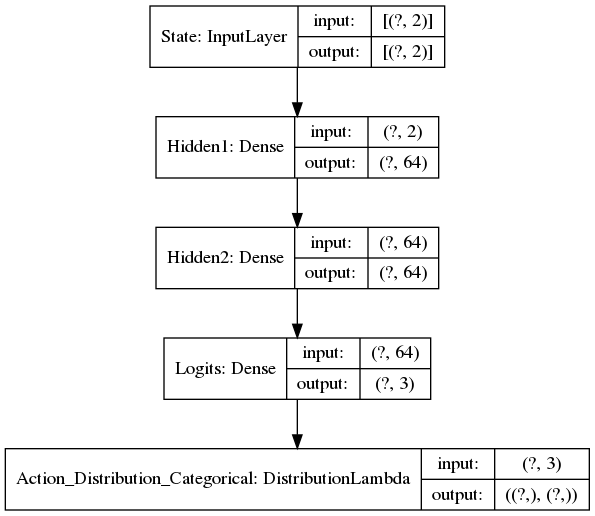

In [12]:
tf.keras.utils.plot_model(policy, show_shapes=True)

### 1.2 Caso contínuo 

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="tanh", input_shape=(10,)),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(10),
    tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t, scale_diag=[1e-2] * 10))
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [14]:
inputs = tf.random.normal(shape=(4, 10))
print(inputs)

tf.Tensor(
[[-0.7566896  -1.4012659  -1.2918531  -1.0614847   0.32760876 -1.4899858
   0.5379313   1.3284984   0.5799186   0.8666134 ]
 [-1.0999258  -0.2729135  -1.0124594   1.6092136   1.2376618   0.76765025
  -0.4854391   1.1944795  -2.508321    0.32169646]
 [ 0.7350903  -1.2825606   0.77931464 -0.5717537  -0.68754786 -1.051087
   0.6365618   0.264257   -1.7764816  -0.29250672]
 [ 1.4333795  -0.06285992  0.89235365 -1.2691898   0.48452634  2.2792509
   0.9805326   0.17177472 -0.23547101 -0.52596396]], shape=(4, 10), dtype=float32)


In [15]:
dist = model(inputs)
print(dist)

tfp.distributions.MultivariateNormalDiag("sequential_2_distribution_lambda_1_MultivariateNormalDiag", batch_shape=[4], event_shape=[10], dtype=float32)


In [16]:
sample = dist.sample()
print(sample)

tf.Tensor(
[[ 0.01484306 -0.06879625  0.7883455   0.03098343 -0.5761249   0.34043354
   0.15781449 -0.14129558  0.44101587 -0.22057182]
 [-0.09214492 -0.06182492  0.5690886   0.48418242 -0.12569898  0.5010416
   0.18962497  0.6186287  -0.96270835  0.742709  ]
 [-0.6956797  -0.05231893 -0.27156422  0.42929003 -0.03964076  0.00220006
  -0.09422887 -0.56170803  0.60105044  0.12272887]
 [-0.45086986 -0.26565406 -1.1957461  -0.07054019  0.2825595   1.0128492
   0.7551321  -0.5197913   0.6217257  -0.5774954 ]], shape=(4, 10), dtype=float32)


In [17]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor([32.629776 28.931648 29.858183 32.16053 ], shape=(4,), dtype=float32)


In [18]:
def build_continuous_policy(obs_space, action_space, hidden_layers, activation="relu", scale_diag=1e-2):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    MultivariateNormalDiag = tfd.MultivariateNormalDiag
    
    policy_net_layers = []
    
    policy_net_layers.append(Input(shape=obs_space.shape, name="State"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))

    policy_net_layers.append(Dense(units=action_space.shape[0], name="Params"))
    policy_net_layers.append(DistributionLambda(
        lambda t: MultivariateNormalDiag(loc=t, scale_diag=[scale_diag] * action_space.shape[0]),
        name="Action_Distribution_Gaussian"
    ))
                                     
    return tf.keras.Sequential(policy_net_layers)

In [19]:
env = gym.make("MountainCarContinuous-v0")

hidden_layers = [32, 32, 32]
activation = "elu"

policy = build_continuous_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()

action_dist = policy(obs[None,:])
print(action_dist)

action = action_dist.sample().numpy()
assert action[0] in env.action_space

tfp.distributions.MultivariateNormalDiag("sequential_3_Action_Distribution_Gaussian_MultivariateNormalDiag", batch_shape=[1], event_shape=[1], dtype=float32)


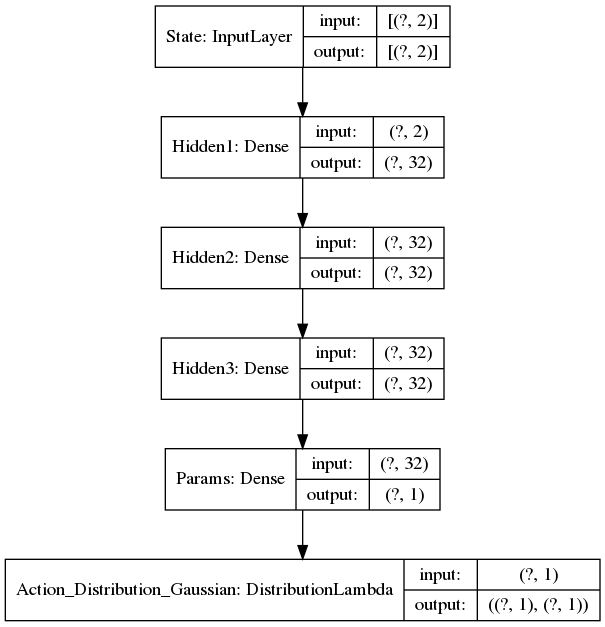

In [20]:
tf.keras.utils.plot_model(policy, show_shapes=True)

## 2. Agente REINFORCE

In [21]:
env = gym.make("MountainCar-v0")

memory = OnPolicyReplay()

total_experiences = 0
n_episodes = 5
total_rewards = []

for _ in range(n_episodes):
    total_reward = 0.0
    obs = env.reset()
    while True:
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        memory.update(obs, action, reward, next_obs, done)
        total_reward += reward
        next_obs = obs
        if done:
            total_rewards.append(total_reward)
            break

batch = memory.sample()

### 2.1 Calculando retornos de episódios

$$
\hat{R}_t = \sum_{t'=t}^T r_{t'}
$$

In [22]:
def compute_returns(batch):
    rewards = batch["rewards"]
    n_episodes = len(rewards)

    returns = []

    for episode in range(n_episodes):
        episode_returns = []
        total_reward = 0.0

        for i in range(len(rewards[episode]) - 1, -1, -1):
            reward = rewards[episode][i]
            total_reward += reward
            episode_returns.append(total_reward)
        
        episode_returns = episode_returns[::-1]
        returns.append(episode_returns)

    return np.array(returns)

In [23]:
returns = compute_returns(batch)
print(returns.shape)

assert len(returns) == n_episodes
assert all(np.allclose(returns[i][0], total_rewards[i]) for i in range(n_episodes))
assert all(np.allclose(np.cumsum(batch["rewards"][i][::-1])[::-1], returns[i]) for i in range(n_episodes))

(5, 200)


### 2.2 Implementação do *surrogate loss*: combinando log-prob e retornos 

In [24]:
class REINFORCE(RLAgent):
    
    def __init__(self, obs_space, action_space, config=None):
        super(REINFORCE, self).__init__(obs_space, action_space, config)
        
        self._build_memory()
        self._build_policy()
        
    def _build_memory(self):
        self.memory = OnPolicyReplay()
        
    def _build_policy(self):
        if isinstance(self.action_space, gym.spaces.discrete.Discrete):
            self.policy = build_discrete_policy(self.obs_space, self.action_space, config["hidden_layers"], config["activation"])
        else:
            self.policy = build_continuous_policy(self.obs_space, self.action_space, config["hidden_layers"], config["activation"])

    def act(self, obs):
        action_dist = self.policy(obs)
        return action_dist.sample().numpy()

    def observe(self, obs, action, reward, next_obs, done):
        self.memory.update(obs, action, reward, next_obs, done)

    def learn(self):
        pass


In [25]:
config = {
    "hidden_layers": [32, 32],
    "activation": "relu"
}

agent = REINFORCE(env.observation_space, env.action_space, config=config)

In [26]:
def compute_log_probs(batch, policy):
    states, actions = batch["states"], batch["actions"]
    n_episodes = len(states)
    
    log_probs = []
    for episode in range(n_episodes):
        states_ = tf.constant(states[episode], dtype=tf.float32)
        actions_ = tf.constant(actions[episode], dtype=tf.float32)
        action_dist = policy(states_)
        log_probs.append(action_dist.log_prob(actions_))
        
    return np.array(log_probs)

In [27]:
log_probs = compute_log_probs(batch, agent.policy)
print(log_probs.shape)

(5, 200)


## 3. Treinamento do agente

## 4. Experimentos 